In [2]:
import os, pandas, platform, torch, torchvision, lightning
import torchvision.models as models

from torch.utils.data import DataLoader, random_split
from lightning import LightningModule, LightningDataModule, Trainer
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from torchvision import datasets, transforms
from pytorch_lightning.loggers import CSVLogger

from torchmetrics import Accuracy, Precision, Recall

torch.manual_seed(17)

name = "clothing-classifier"
log_path = "logs"

print("Versions: python", platform.python_version(), "| torch", torch.__version__, "| torchvision", torchvision.__version__, "| lightning", lightning.__version__, "| pandas", pandas.__version__)

Versions: python 3.10.11 | torch 2.4.1+cu121 | torchvision 0.19.1+cu121 | lightning 2.5.0.post0 | pandas 2.2.1


In [3]:
data_path = "data"
data_folder = "train"
data_repo_user = "alexeygrigorev"
data_repo_name = "clothing-dataset-small"
if not os.path.exists(os.path.join(data_path, data_repo_name)):
    download_and_extract_repo(data_repo_user, data_repo_name, data_path)
    print("Downloaded dataset", data_repo_name)
else:
    print("The dataset", data_repo_name, "was found locally, no need to download it.")
data_path = os.path.join(data_path, data_repo_name, data_folder)
print("Using", data_path)

The dataset clothing-dataset-small was found locally, no need to download it.
Using data\clothing-dataset-small\train


## Create a dataset

In [ ]:
class ImageFolderDataSet(LightningDataModule):
    def __init__(self, path, split=[.6, .2, .2], img_size=(224,224), batch_size=32, num_workers=int(os.cpu_count()/2)):
        super().__init__()
        self.path = path
        self.split = split
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
        ])

    def setup(self, stage=None):
        self.data = datasets.ImageFolder(self.path, transform=self.transform)
        self.train, self.val, self.test = random_split(self.data, self.split)

    def train_dataloader(self):
        return DataLoader(self.train, shuffle=True, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=True)
    
    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=True)
    
    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=True)

    def classes(self):
        return self.data.classes



dataset = ImageFolderDataSet(data_path)
dataset.setup()
classes = dataset.classes()
print("Created an image dataset for classes:", classes)

Created an image dataset for classes: ['dress', 'hat', 'longsleeve', 'outwear', 'pants', 'shirt', 'shoes', 'shorts', 'skirt', 't-shirt']


## Create a model

In [5]:
class ImageClassifierModel(LightningModule):
    def __init__(self, num_classes, learning_rate=2e-4):
        super().__init__()
        backbone = models.resnet18(weights="DEFAULT")
        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]
        self.feature_extractor = torch.nn.Sequential(*layers)
        self.feature_extractor.eval()
        self.classifier = torch.nn.Linear(num_filters, num_classes)
        self.learning_rate = learning_rate
        self.criterion = torch.nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.precision = Precision(task="multiclass", num_classes=num_classes, average="macro")
        self.recall = Recall(task="multiclass", num_classes=num_classes, average="macro")        

    def forward(self, x):
        with torch.no_grad():
            representations = self.feature_extractor(x).flatten(1)
        return self.classifier(representations)
    
    def training_step(self, batch):
        x, y = batch
        out = self(x)
        loss = self.criterion(out, y)
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        return loss
    
    def validation_step(self, batch):
        x, y = batch
        out = self(x)
        preds = out.argmax(dim=1)
        self.log("val_loss", self.criterion(out, y), on_step=False, on_epoch=True)
        self.log("val_accuracy", self.accuracy(preds, y), on_step=False, on_epoch=True)
        self.log("val_precision", self.precision(preds, y), on_step=False, on_epoch=True)
        self.log("val_recall", self.recall(preds, y), on_step=False, on_epoch=True)
    
    def test_step(self, batch):
        x, y = batch
        out = self(x)
        preds = out.argmax(dim=1)
        self.log("test_accuracy", self.accuracy(preds, y), on_step=False, on_epoch=True)
        self.log("test_precision", self.precision(preds, y), on_step=False, on_epoch=True)
        self.log("test_recall", self.recall(preds, y), on_step=False, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate) 



model = ImageClassifierModel(num_classes=len(classes))

In [6]:
logger = CSVLogger(log_path, name=name)

In [7]:
early_stop_callback = EarlyStopping(monitor="val_accuracy", min_delta=0.00, patience=3, verbose=False, mode="max")

In [8]:
trainer = Trainer(logger=logger, max_epochs=999, callbacks=[early_stop_callback])
trainer.fit(model, datamodule=dataset)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type                | Params | Mode 
------------------------------------------------------------------
0 | feature_extractor | Sequential          | 11.2 M | eval 
1 | classifier        | Linear              | 5.1 K  | train
2 | criterion         | CrossEntropyLoss    | 0      | train
3 | accuracy          | MulticlassAccuracy  | 0      | train
4 | precision         | MulticlassPrecision | 0      | train
5 | recall            | MulticlassRecall    

Epoch 18: 100%|██████████| 58/58 [00:04<00:00, 13.84it/s, v_num=0]         


## Stats

In [9]:
metrics = pandas.read_csv(os.path.join(log_path, name, "version_" + str(logger.version), "metrics.csv"))

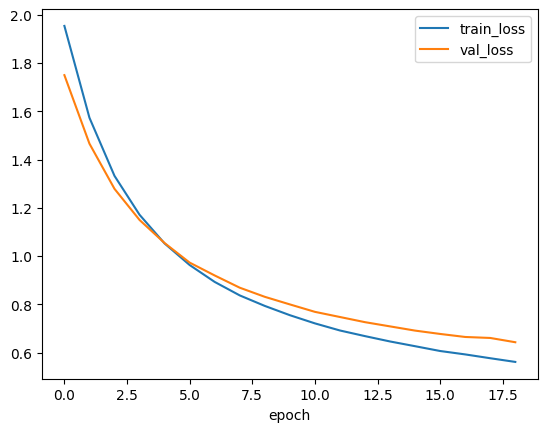

In [10]:
loss_metrics = metrics[["epoch", "train_loss", "val_loss"]].groupby("epoch").first().reset_index().dropna().set_index("epoch")
plot = loss_metrics.plot()

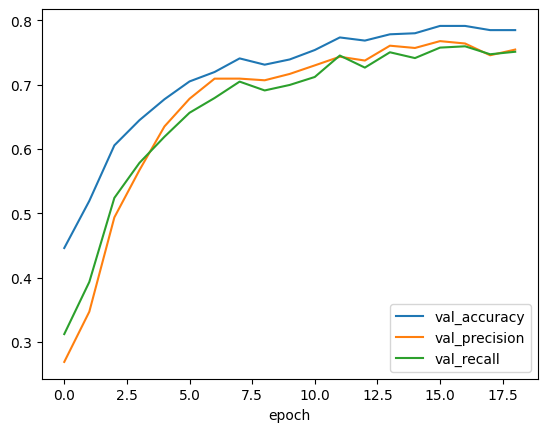

In [11]:
val_metrics = metrics[["epoch", "val_accuracy", "val_precision", "val_recall"]].groupby("epoch").first().reset_index().dropna().set_index("epoch")
plot = val_metrics.plot()

## Test

In [12]:
result = trainer.test(model, datamodule=dataset)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 23.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8368678689002991
     test_precision          0.803468644618988
       test_recall           0.784110963344574
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
